In [27]:

import pandas as pd

# tulostusasetukset niin, että kaikki rivit ja sarakkeet näkyvät

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


In [28]:
import geopandas as gpd

# Shapefile joen keskiviiva
joen_keskiviiva = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\joki_centerline2.shp')

print(joen_keskiviiva)

   FID_  FID_joki_S    SHAPE_Leng  InLine_FID   
0     1           0  32602.237884           1  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

<Axes: >

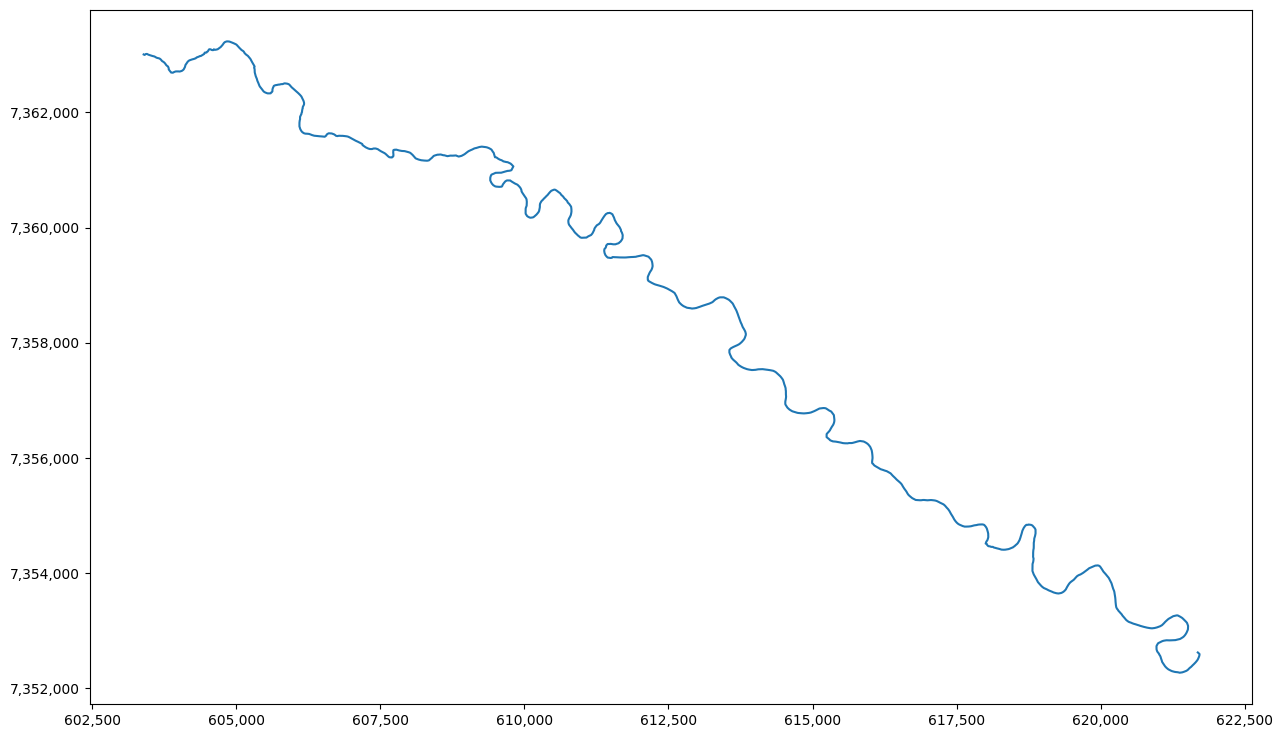

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Kuvakoko
fig, ax = plt.subplots(figsize=(15, 10))

# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

# Joen plottaus
joen_keskiviiva.plot(ax=ax)

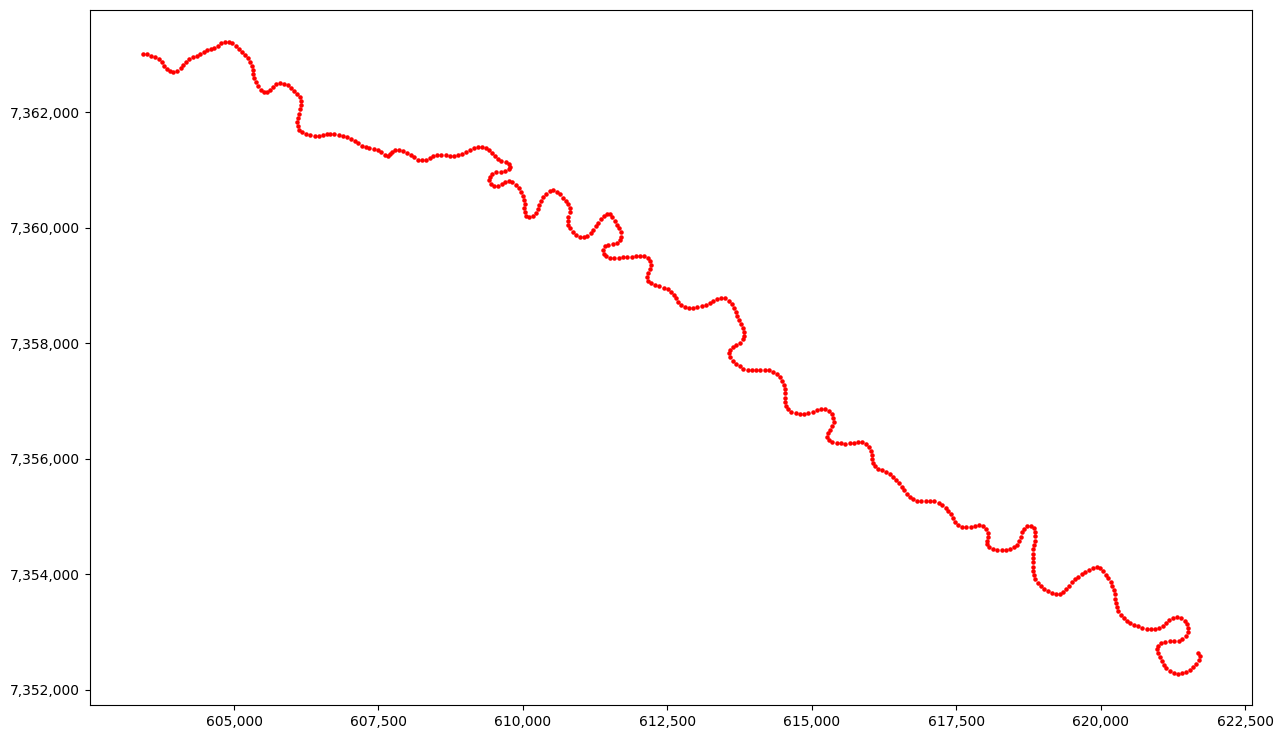

In [30]:
from shapely.geometry import LineString, Point
from scipy.signal import savgol_filter


# GeoDataFrame pisteitä varten 
pisteet100 = gpd.GeoDataFrame(columns=['geometry'])

#funktio jakopisteiden luomiselle
def create_breakpoints(geometry, interval):

    breakpoints = LineString(geometry).interpolate(range(0, int(geometry.length), interval))

    #Smooth the points using Savitzky-Golay filtering
    x_coords = [point.x for point in breakpoints]
    y_coords = [point.y for point in breakpoints]
    smoothed_x = savgol_filter(x_coords, window_length=7, polyorder=3)
    smoothed_y = savgol_filter(y_coords, window_length=7, polyorder=3)
    
    smoothed_breakpoints = [Point(x, y) for x, y in zip(smoothed_x, smoothed_y)]

    #Lisää point geodataframeen
    point = gpd.GeoDataFrame(geometry=smoothed_breakpoints, crs='EPSG:3067')
    return point[::-1]



# Jaa 100m välein
pisteet100 = create_breakpoints(joen_keskiviiva['geometry'].iloc[0], 75)

# Kuvakoko, kaksi kuvaa
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20))
fig, ax = plt.subplots(figsize=(15, 15))
# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))




# Plottaa point
pisteet100.plot(ax=ax, color='red', marker='o', markersize=5)


# Näytä kaavio
plt.show()


434    POINT (603419.508 7363006.352)
433    POINT (603489.631 7362994.134)
432    POINT (603560.322 7362974.173)
431    POINT (603629.082 7362945.914)
430    POINT (603694.079 7362908.347)
429    POINT (603747.764 7362859.966)
428    POINT (603791.850 7362797.725)
427    POINT (603834.723 7362744.514)
426    POINT (603886.095 7362707.767)
425    POINT (603951.058 7362694.761)
424    POINT (604018.551 7362713.879)
423    POINT (604073.960 7362759.410)
422    POINT (604119.453 7362812.096)
421    POINT (604165.353 7362868.037)
420    POINT (604219.831 7362912.424)
419    POINT (604288.037 7362943.269)
418    POINT (604358.237 7362969.015)
417    POINT (604419.382 7363008.023)
416    POINT (604477.204 7363044.509)
415    POINT (604536.252 7363068.578)
414    POINT (604598.480 7363085.941)
413    POINT (604661.021 7363106.879)
412    POINT (604721.572 7363140.377)
411    POINT (604778.989 7363186.235)
410    POINT (604840.517 7363217.391)
409    POINT (604905.761 7363218.767)
408    POINT

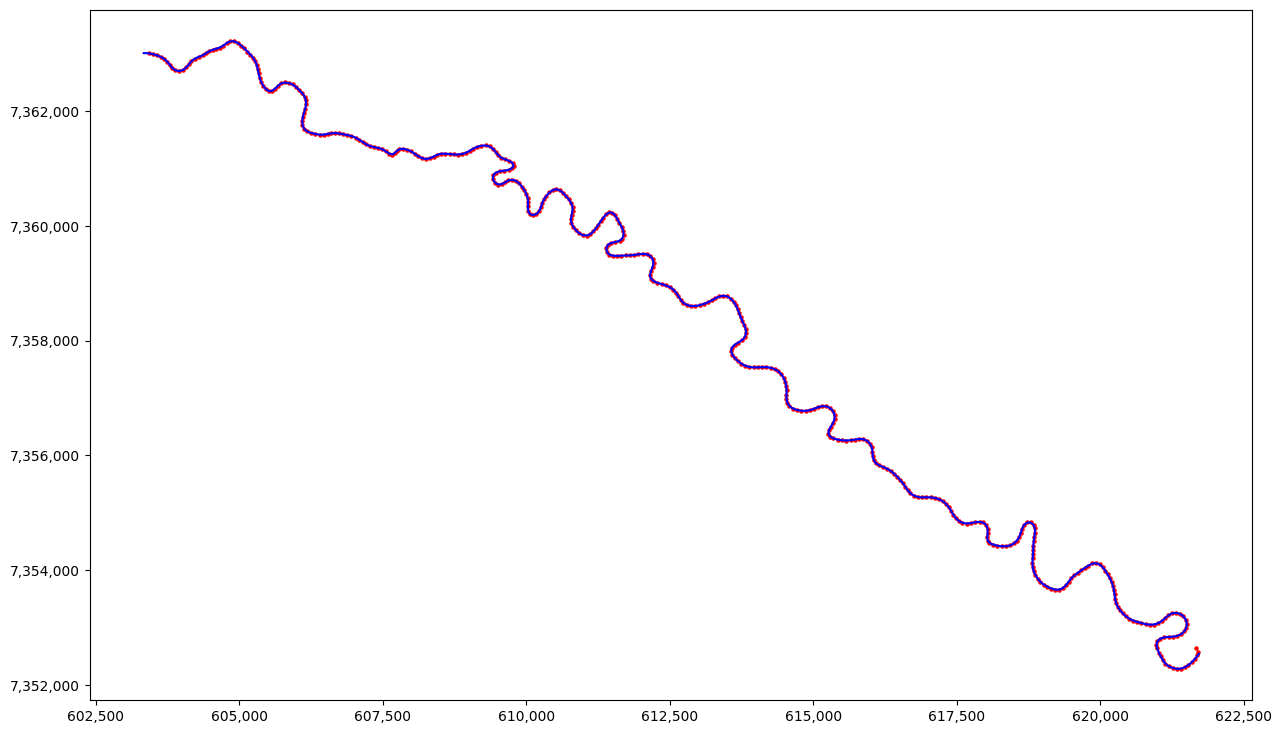

In [31]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import BSpline
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Import FuncFormatter explicitly

def create_nurbs(points):
    x, y = zip(*points)

    # Use spline and do not allow extrapolation
    t = np.linspace(0, 1, len(points))
    spl = BSpline(t, list(zip(x, y)), 2, extrapolate=True)

    t_new = np.linspace(0, 1, 600)
    spline_points = [Point(coord) for coord in zip(spl(t_new)[:, 0], spl(t_new)[:, 1])]


    bspline = LineString(spline_points)
    bspline_gdf = gpd.GeoDataFrame(geometry=list(spline_points))
   

    return bspline, bspline_gdf

# Generate NURBS curve
spline100, spline100_gdf = create_nurbs(pisteet100['geometry'].apply(lambda point: (point.x, point.y)).tolist())
print(pisteet100['geometry'])

# Plotting
fig, ax = plt.subplots(figsize=(15, 12))

# x and y axes formatting
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

# Plot NURBS line
gpd.GeoDataFrame(geometry=[spline100]).plot(ax=ax, color='blue')

# Plot points
pisteet100.plot(ax=ax, color='red', marker='o', markersize=5)

plt.show()


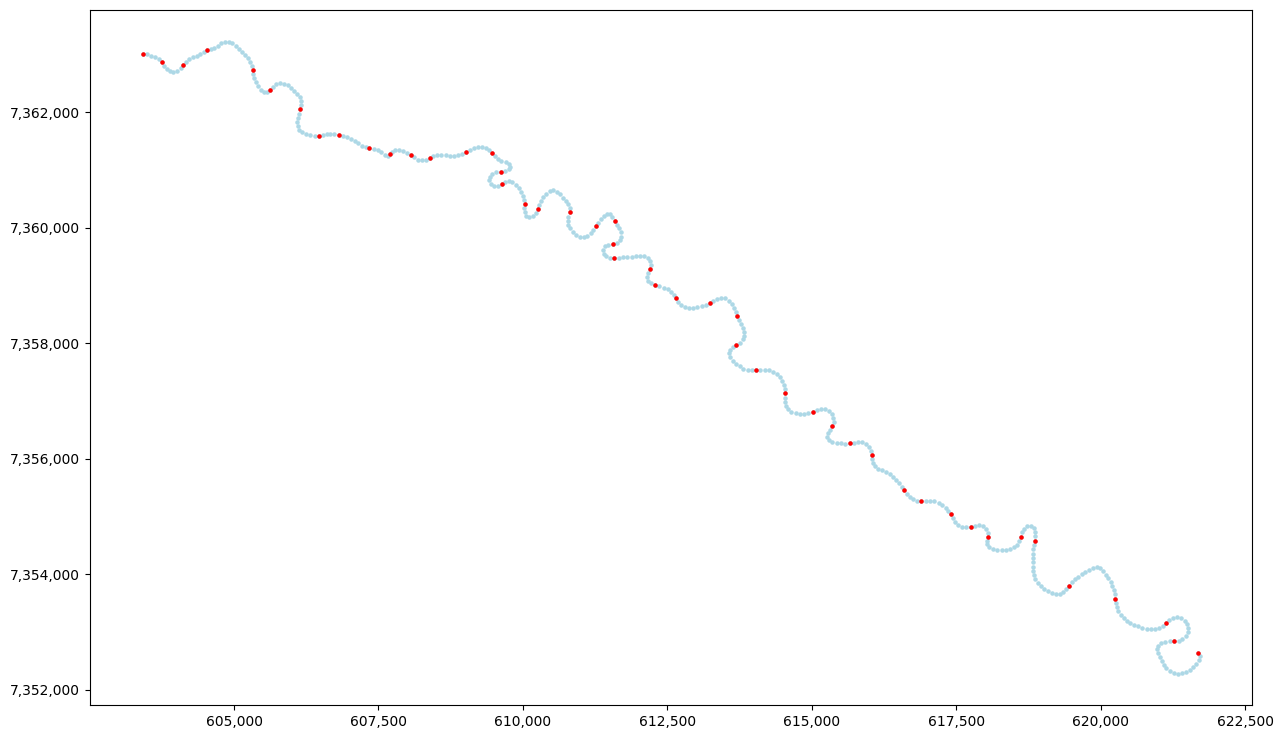

In [50]:
#KÄÄNNEpoints f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T avulla, Analyyttinen geometria 2016 s.6
import numpy as np
from numpy import linalg

def define_inflectionpoints(points, p_between):
    inflectionpoint_list = []
    points_in_between=0
    inflectionpoint_list.append(points.iloc[0]) #eka

    for i in range(1, len(points)-2):
        v1 = (np.array(points.iloc[i-1].coords[0])) - (np.array(points.iloc[i].coords[0]))
        v2 = (np.array(points.iloc[i].coords[0])) - (np.array(points.iloc[i+1].coords[0]))
        v2_orto = np.array([-v2[1], v2[0]])
        
        v3 = (np.array(points.iloc[i+1].coords[0])) - (np.array(points.iloc[i+2].coords[0]))
        v3_orto = np.array([-v3[1], v3[0]])


        dot_product1 = np.dot(v1, v2_orto)
        dot_product2 = np.dot(v2, v3_orto)

        points_in_between = points_in_between + 1
        
        if np.sign(dot_product1) != np.sign(dot_product2)  and points_in_between > p_between:
            inflectionpoint_list.append(points.iloc[i])
            
            points_in_between = 0
    inflectionpoint_list.append(points.iloc[len(points)-1]) #vipa
    
    return inflectionpoint_list


#Etsitään käännepoints
kaannepisteet100 = define_inflectionpoints(pisteet100['geometry'], 4)


# Kuvakoko, kaksi kuvaa
fig, ax = plt.subplots(figsize=(15, 12))

# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

# Piirrä muut points sinisenä
#pisteet200.plot(ax=ax, color='blue', marker='o', markersize=8, label='points p_i')
pisteet100.plot(ax=ax, color='lightblue', marker='o', markersize=5, label='points p_i')


# Piirrä käännepoints punaisena
#gpd.GeoDataFrame(geometry=kaannepisteet200).plot(ax=ax1, color='red', marker='o', markersize=8, label='Käännepoints')
gpd.GeoDataFrame(geometry=kaannepisteet100).plot(ax=ax, color='red', marker='o', markersize=5, label='Käännepoints')

plt.show()


In [33]:
#points, janat, keskinormaalit, leikkauspisteet, ympyrän säde

import numpy as np


def radius_and_intersectionpoint(points):
    radius_list = []
    intersectionpoint_list = []


    for i in range(len(points) - 2):

        # kolme peräkkäistä pistettä
        p1 = np.array(points['geometry'].iloc[i].coords[0])
        p2 = np.array(points['geometry'].iloc[i + 1].coords[0])
        p3 = np.array(points['geometry'].iloc[i + 2].coords[0])

        # Lasketaan janojen keskinormaalien leikkauspiste
        midpoint1 = 0.5 * (p1 + p2)
        normal1 = np.array([-(p2 - p1)[1], (p2 - p1)[0]])

        midpoint2 = 0.5 * (p2 + p3)
        normal2 = np.array([-(p3 - p2)[1], (p3 - p2)[0]])

        # Muodostetaan yhtälöpari
        A = np.array([[normal1[0], -normal2[0]], [normal1[1], -normal2[1]]])
        B = np.array([midpoint2[0] - midpoint1[0], midpoint2[1] - midpoint1[1]])
        if np.linalg.det(A) == 0:
            print("Singular matrix. Skipping this point.")
            continue
        else:
        # Ratkaistaan yhtälöpari
            solution = np.linalg.solve(A, B)

            # Lasketaan leikkauspiste
            intersection_points = midpoint1 + solution[1] * normal1
            intersectionpoint_list.append(intersection_points)
        
            # Lasketaan ympyrän keskipiste ja säde
            radius = np.linalg.norm(intersection_points - p2)
            radius_list.append(radius)

    return radius_list, intersectionpoint_list, solution, A, B 

sade100, inter100, sol100, A100, B100 = radius_and_intersectionpoint(pisteet100)

print("R 100:", sade100)




R 100: [682.7578261480138, 636.7346938744126, 551.9595673496816, 366.1162255606672, 319.01300339550573, 1302.982571265061, 262.66876674168196, 146.8134101309906, 137.28461428785081, 169.67531035701649, 426.9942614176538, 2716.753659266386, 367.8149866686601, 263.7724339769559, 1023.4948989544382, 351.63576995378344, 15053.324135455996, 403.37730783714767, 551.3601037023857, 1255.0267270999132, 353.85144286846577, 398.9027652911985, 370.4497516541839, 159.77624402049108, 140.16202333615644, 289.654489130804, 971.1019953234055, 2518.9352848440208, 2430.967905690341, 1881.7049685267782, 458.16429432978856, 355.93610591951585, 604.494043390088, 2580.4980668240637, 4313.901615639825, 509.31528706084964, 736.4023341909071, 381.08857896962746, 243.09683587704217, 122.68829588609512, 88.89381575966304, 400.6803146771884, 581.4587821265386, 161.58062553058986, 185.0274956636051, 292.2655060418365, 282.12300702131165, 468.6263980018436, 2256.4252322948664, 609.1913984670023, 249.8735161967864, 2

                           geometry  curvature
434  POINT (603419.508 7363006.352)        NaN
433  POINT (603489.631 7362994.134)   0.001465
432  POINT (603560.322 7362974.173)   0.001571
431  POINT (603629.082 7362945.914)   0.001812
430  POINT (603694.079 7362908.347)   0.002731
429  POINT (603747.764 7362859.966)   0.003135
428  POINT (603791.850 7362797.725)   0.000767
427  POINT (603834.723 7362744.514)   0.003807
426  POINT (603886.095 7362707.767)   0.006811
425  POINT (603951.058 7362694.761)   0.007284
424  POINT (604018.551 7362713.879)   0.005894
423  POINT (604073.960 7362759.410)   0.002342
422  POINT (604119.453 7362812.096)   0.000368
421  POINT (604165.353 7362868.037)   0.002719
420  POINT (604219.831 7362912.424)   0.003791
419  POINT (604288.037 7362943.269)   0.000977
418  POINT (604358.237 7362969.015)   0.002844
417  POINT (604419.382 7363008.023)   0.000066
416  POINT (604477.204 7363044.509)   0.002479
415  POINT (604536.252 7363068.578)   0.001814
414  POINT (6

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


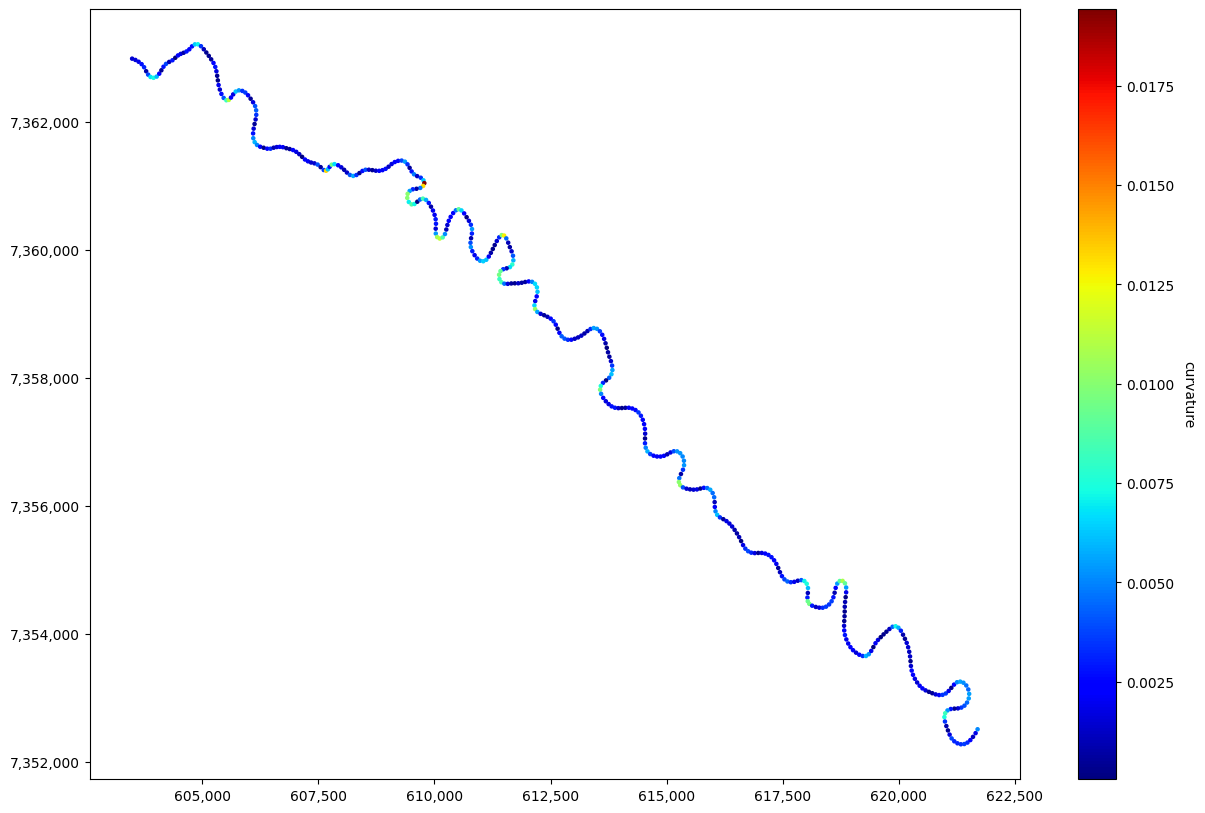

In [34]:
#KAAAREVUUUS 1/R 100


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def calculate_curvature(points, radius):
    curvature_list = []
    shifted_radius = [np.nan] + radius[:-1]

    points['curvature'] = np.nan

    for i in range(len(points) - 2):
        radius = shifted_radius[i]
        curvature = 1 / radius
        curvature_list.append(curvature)

    # Kaarevuusarvoja ei kahdelle ekalle pisteessä
    points['curvature'][:-2] = curvature_list


calculate_curvature(pisteet100, sade100)

print(pisteet100)


fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    pisteet100.geometry.x,
    pisteet100.geometry.y,
    c=pisteet100['curvature'],
    cmap='jet',
    s=5
)

    # Lisää värikartan selitys
cbar = plt.colorbar(scatter, label='Curvature')
cbar.set_label('curvature', rotation=270, labelpad=15)

    # x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

plt.show()


In [35]:
#MÄÄRITELLÄÄN halfmeander

def define_halfmeander(points, inflectionpoints):
    points['halfmeander'] = None
    halfmeander_id = 0
    j = 1

    for i in range(len(points['geometry'])):
        if points['geometry'].iloc[i].coords[0] == inflectionpoints[j].coords[0]:
            points.at[len(points) - i - 1, 'halfmeander'] = halfmeander_id
            halfmeander_id += 1
            if j != len(inflectionpoints) - 1:
                j += 1
        else:
            points.at[len(points) - i - 1, 'halfmeander'] = halfmeander_id

# Example usage for 200m interval
# define_halfmeander(pisteet200, kaannepisteet200)

# Example usage for 200m interval
define_halfmeander(pisteet100, kaannepisteet100)

print(pisteet100)



                           geometry  curvature halfmeander
434  POINT (603419.508 7363006.352)        NaN           0
433  POINT (603489.631 7362994.134)   0.001465           0
432  POINT (603560.322 7362974.173)   0.001571           0
431  POINT (603629.082 7362945.914)   0.001812           0
430  POINT (603694.079 7362908.347)   0.002731           0
429  POINT (603747.764 7362859.966)   0.003135           0
428  POINT (603791.850 7362797.725)   0.000767           1
427  POINT (603834.723 7362744.514)   0.003807           1
426  POINT (603886.095 7362707.767)   0.006811           1
425  POINT (603951.058 7362694.761)   0.007284           1
424  POINT (604018.551 7362713.879)   0.005894           1
423  POINT (604073.960 7362759.410)   0.002342           1
422  POINT (604119.453 7362812.096)   0.000368           1
421  POINT (604165.353 7362868.037)   0.002719           2
420  POINT (604219.831 7362912.424)   0.003791           2
419  POINT (604288.037 7362943.269)   0.000977          

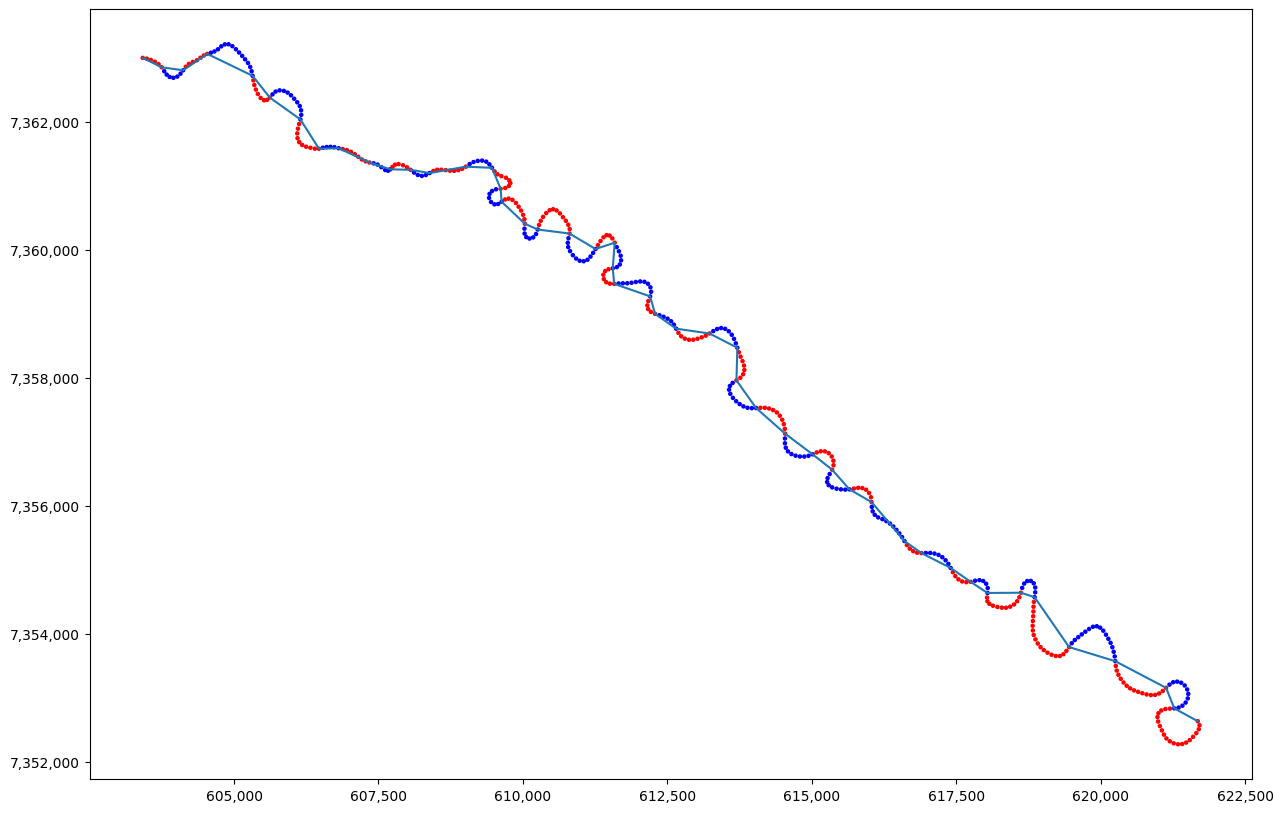

In [36]:
#Erottaa väreillä puolimeanderit ja plottaa

from matplotlib.colors import ListedColormap

colors = ['red' if i % 2 == 0 else 'blue' for i in range(pisteet100['halfmeander'].nunique())]
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    pisteet100.geometry.x,
    pisteet100.geometry.y,
    c=pisteet100['halfmeander'],
    cmap=cmap,
    s=5
)
#JANAT KÄÄNNEPISTEIDEN VÄLIIN
# Erota x- ja y-koordinaatit
kaanne100_x_coordinates = [point.x for point in kaannepisteet100]
kaanne100_y_coordinates = [point.y for point in kaannepisteet100]
# Piirrä janat pisteiden välille
plt.plot(kaanne100_x_coordinates, kaanne100_y_coordinates, linestyle='-')

# Aseta x- ja y-akselien muotoilu
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))



plt.show()

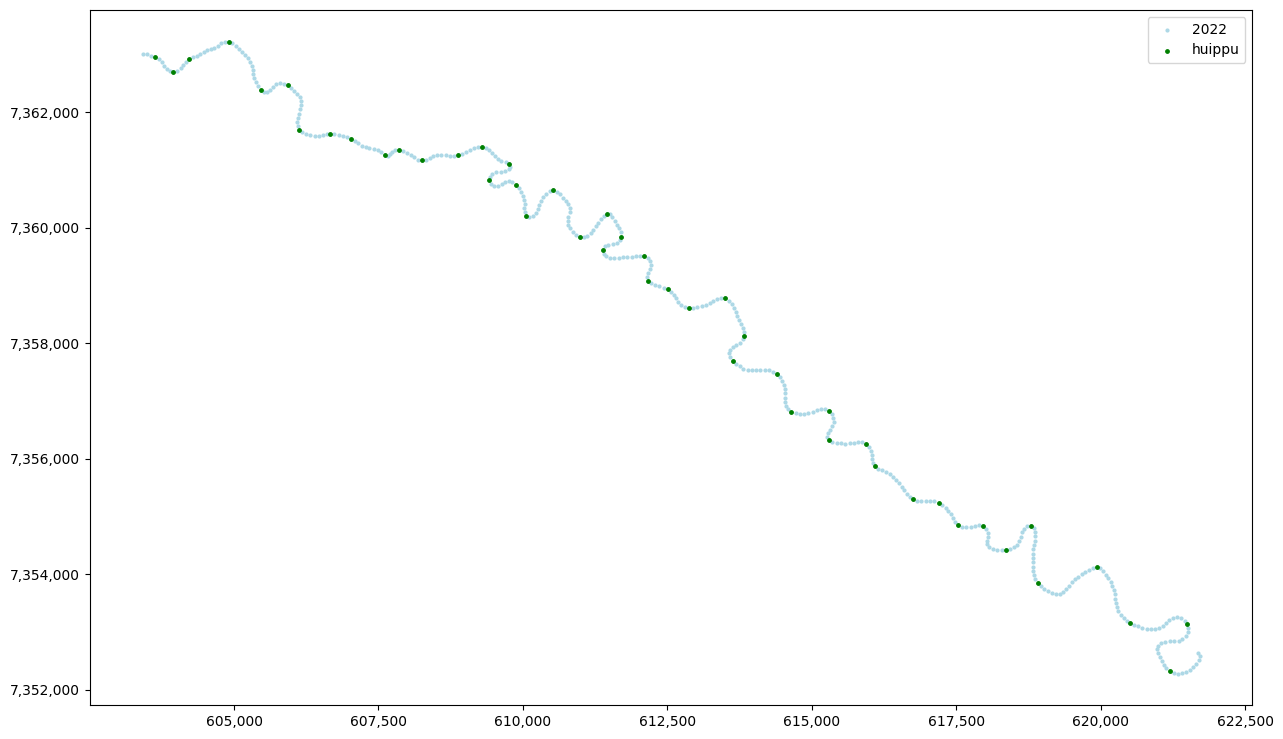

In [37]:
import numpy as np
from shapely.geometry import Point, LineString

def define_top_points(inflection_points, points):
    farthest_points = [] 
    max_distance = 0
    
    
    for i in range(len(inflection_points) - 1):
        p1 = inflection_points[i]
        p2 = inflection_points[i + 1]
        
        # Create a LineString from the two inflection points
        line = LineString([p1, p2])
        
        # Filter points based on halfmeander column
        halfmeander_points = points[points['halfmeander'] == i]
        
        # Initialize a list to store distances
        dist = []
        
        # Calculate distances of all points between the inflection points from the line
        for j in range(len(halfmeander_points)):
            distance = line.distance(halfmeander_points['geometry'].iloc[j])
            dist.append(distance)
        
        max_distance = max(dist)  # Get the maximum distance for this segment
        farthest_point_index = dist.index(max_distance)  # Find the index of the farthest point
        farthest_point = halfmeander_points['geometry'].iloc[farthest_point_index]  # Get the farthest point
        
        farthest_points.append(farthest_point)  # Append the farthest point
        
    return farthest_points

# 2022
huippupisteet = define_top_points(kaannepisteet100, pisteet100)

# Kuvakoko, kaksi kuvaa
fig, ax = plt.subplots(figsize=(15, 12))

# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

pisteet100.plot(ax=ax, color='lightblue', marker='o', markersize=4, label= '2022')

# top
gpd.GeoDataFrame(geometry=huippupisteet).plot(ax=ax, color='green', marker='o', markersize=6, label='huippu')


# Show legend
ax.legend()

plt.show()

                           geometry  curvature halfmeander norm_curvature
434  POINT (603419.508 7363006.352)        NaN           0            NaN
433  POINT (603489.631 7362994.134)   0.001465           0       0.467242
432  POINT (603560.322 7362974.173)   0.001571           0       0.501014
431  POINT (603629.082 7362945.914)   0.001812           0       0.577964
430  POINT (603694.079 7362908.347)   0.002731           0       0.871344
429  POINT (603747.764 7362859.966)   0.003135           0            1.0
428  POINT (603791.850 7362797.725)   0.000767           1       0.105362
427  POINT (603834.723 7362744.514)   0.003807           1       0.522653
426  POINT (603886.095 7362707.767)   0.006811           1       0.935096
425  POINT (603951.058 7362694.761)   0.007284           1            1.0
424  POINT (604018.551 7362713.879)   0.005894           1       0.809102
423  POINT (604073.960 7362759.410)   0.002342           1       0.321514
422  POINT (604119.453 7362812.096)   

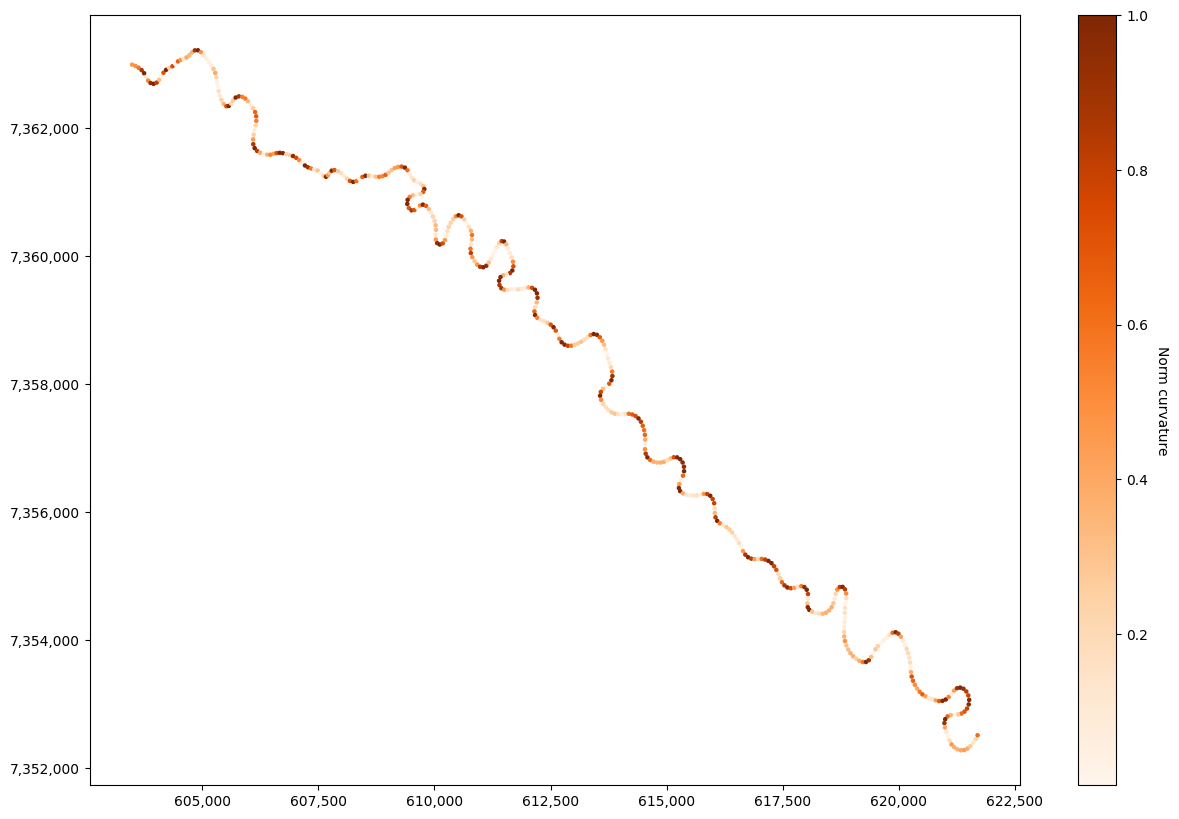

In [38]:
#NORMALISOITU KAAREVUUS k(x_i,j)/K_M_j


def define_normalized_curvature(points):
    points['norm_curvature'] = None

    for i in range(max(points['halfmeander'])+1): 

            pm = (points['halfmeander'] == i)
            filtered_pm = points[pm]

            maxcurvature = filtered_pm['curvature'].max()

            # Iterate through the index of filtered_pm
            for index in filtered_pm.index:
                # Use loc to set values in the original dataframe
                points.loc[index, 'norm_curvature'] = filtered_pm.loc[index, 'curvature'] / maxcurvature

define_normalized_curvature(pisteet100)

print(pisteet100)



fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    pisteet100.geometry.x,
    pisteet100.geometry.y,
    c=pisteet100['norm_curvature'],
    cmap='Oranges',
    s=5
)

    # Lisää värikartan selitys
cbar = plt.colorbar(scatter, label='Norm curvature')
cbar.set_label('Norm curvature', rotation=270, labelpad=15)

    # x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

plt.show()
                  

     Id  gridcode    Shape_Leng    Shape_Area   
0  5126         1  86290.411758  1.443594e+07  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

<Axes: >

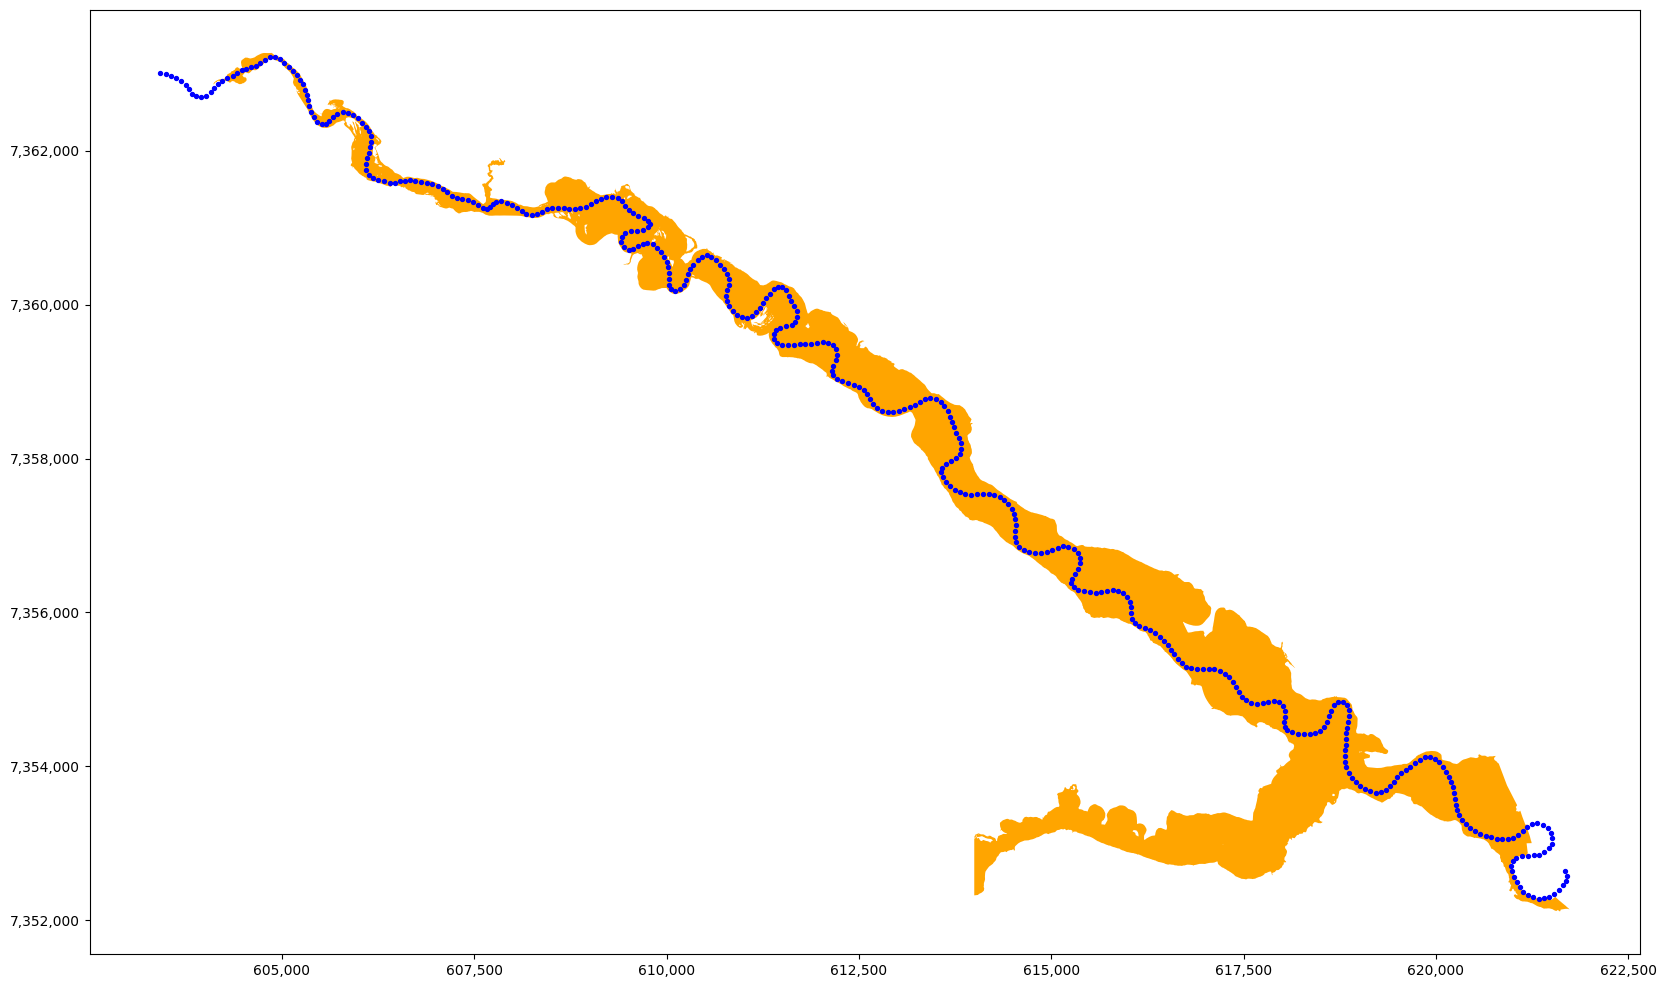

In [39]:
import geopandas as gpd
from shapely.geometry import Point

# Lataa sallittu alue shapefilena
sallittu_alue = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\sallittualue.shp')

print(sallittu_alue)


for i in range(len(pisteet100)):
    # Tarkista, onko jokisijainti sallitulla alueella
    if pisteet100['geometry'].iloc[i].within(sallittu_alue.geometry.iloc[0]):
        print("Pisteen sijainti on sallitulla alueella.", pisteet100['geometry'].iloc[i])
    else:
        print("Pisteen sijainti ei ole sallitulla alueella.")

 #kuvakoko
fig, ax = plt.subplots(figsize=(20, 15))

    # x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
        return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

sallittu_alue.plot(ax=ax, color = 'orange')

pisteet100.plot(ax=ax, color='blue', marker='o', markersize=8, label='points p_i')

In [40]:
def check_feasible_region(edellinen, point, feasibleregion):

    # Tarkista, onko piste sallitulla alueella

    #Jos on alueella niin uusi piste on 
    if Point(point).within(feasibleregion.geometry.iloc[0]):
        new_p = Point(point)
    else:
        new_p = edellinen

    return new_p
    

In [41]:
#UUSI OXBOWLAKE

#JOS KÄÄNNEPISTEIDEN ETÄISYYS ALLE X metriä

def new_oxbow(points, inflection, meters):
    # Make a copy of the DataFrame to avoid modifying the original DataFrame

    oxbows= []

    new_points = points.copy() 
    
    for i in range(len(inflection)-1):

        if inflection[i].distance(inflection[i+1]) < meters:

            # Drop rows from new_points where 'halfmeander' column equals 1

            owbowpoint_index = (new_points['halfmeander'] == i)
            oxbow_points = new_points[owbowpoint_index]

            oxbows.append(oxbow_points)


            new_points = new_points[new_points['halfmeander'] != i]


    
    return new_points, oxbows

# Example usage
# Assuming pisteet100 and kaannepisteet100 are defined elsewhere
uusipisteet, ox = new_oxbow(pisteet100, kaannepisteet100, 30)
print(ox)
print(uusipisteet)

[]
                           geometry  curvature halfmeander norm_curvature
434  POINT (603419.508 7363006.352)        NaN           0            NaN
433  POINT (603489.631 7362994.134)   0.001465           0       0.467242
432  POINT (603560.322 7362974.173)   0.001571           0       0.501014
431  POINT (603629.082 7362945.914)   0.001812           0       0.577964
430  POINT (603694.079 7362908.347)   0.002731           0       0.871344
429  POINT (603747.764 7362859.966)   0.003135           0            1.0
428  POINT (603791.850 7362797.725)   0.000767           1       0.105362
427  POINT (603834.723 7362744.514)   0.003807           1       0.522653
426  POINT (603886.095 7362707.767)   0.006811           1       0.935096
425  POINT (603951.058 7362694.761)   0.007284           1            1.0
424  POINT (604018.551 7362713.879)   0.005894           1       0.809102
423  POINT (604073.960 7362759.410)   0.002342           1       0.321514
422  POINT (604119.453 7362812.096)

In [42]:
#MÄÄRITTELEE SUUNNAT D JA L , missä L on 90asteen kulmassa D vasten
import math


def define_directions(inflectionpoints):
    D_list = []
    L_perp_list = []
    
    for i in range(len(inflectionpoints) - 1):
        x1, y1 = inflectionpoints[i].x, inflectionpoints[i].y
        x2, y2 = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Calculate direction vector v
        v = (x2 - x1, y2 - y1)

        # Calculate the length of the vector v
        v_length = math.sqrt(v[0] ** 2 + v[1] ** 2) 

        # Normalize direction vector
        # Parallel direction D
        D = (v[0] / v_length, v[1] / v_length)

        # Perpendicular direction L
        L = (- D[1], D[0])

        D_list.append(D)
        L_perp_list.append(L)

    return D_list, L_perp_list

D100, L100_perp = define_directions(kaannepisteet100)
print("D:", D100)
print("L:", L100_perp)



D: [(0.9133000259567561, -0.4072874446719282), (0.9918081286753577, -0.1277365879201619), (0.8516670862602096, 0.5240831748692614), (0.9165676520085686, -0.3998796560110296), (0.6592171561548908, -0.7519526188737281), (0.8399590166549977, -0.542649841370998), (0.5740321466056579, -0.8188327635502259), (0.9997522675468543, 0.022257662386757502), (0.9222173658932943, -0.38667186352879834), (0.9596710630703204, -0.28112532917807564), (0.9997473359683088, -0.022478083198299074), (0.9883355702012805, -0.1522918273411603), (0.9876650820571317, 0.1565812430819202), (0.9992320886705964, -0.03918204909135544), (0.41366447507055154, -0.9104294053163074), (0.08575658550531107, -0.9963161185298922), (0.7593708393881291, -0.6506580732512032), (0.9267755614387333, -0.3756155730529829), (0.9935001687951303, -0.113830640005438), (0.8815140852292491, -0.4721577252809066), (0.9585241058637622, 0.2850114707833262), (-0.08313640625236152, -0.9965381768680226), (0.09975511509125762, -0.9950120185269774), (

In [43]:
#MÄÄRITTELEE SUUNNAT D JA L, missä L on top pisteeesen suunnattu 
import math


def define_directions_top(inflectionpoints, toppoints):
    D_list = []
    L_top_list = []
    j = 0
    
    for i in range(len(inflectionpoints) - 1):
        x1_inf, y1_inf = inflectionpoints[i].x, inflectionpoints[i].y
        x2_inf, y2_inf = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Calculate direction vector v
        v_inf = (x2_inf - x1_inf, y2_inf - y1_inf)

        # Calculate the length of the vector v
        v_inf_length = math.sqrt(v_inf[0] ** 2 + v_inf[1] ** 2) 

        # Normalize direction vector
        # Parallel direction D
        D = (v_inf[0] / v_inf_length, v_inf[1] / v_inf_length)

        # top direction L

        x_mid , y_mid  = 0.5*(x1_inf + x2_inf) , 0.5*(y1_inf + y2_inf)

        x_top, y_top = toppoints[j].x, toppoints[j].y
        j = j+1

        v_top = (x_top - x_mid, y_top - y_mid)

        v_top_length = math.sqrt(v_top[0] ** 2 + v_top[1] ** 2)

        L = (v_top[0] / v_top_length, v_top[1] / v_top_length)

        D_list.append(D)
        L_top_list.append(L)

    return D_list, L_top_list

D100, L_top = define_directions_top(kaannepisteet100, huippupisteet)
print("D:",  D100)
print("L top:", L_top)


D: [(0.9133000259567561, -0.4072874446719282), (0.9918081286753577, -0.1277365879201619), (0.8516670862602096, 0.5240831748692614), (0.9165676520085686, -0.3998796560110296), (0.6592171561548908, -0.7519526188737281), (0.8399590166549977, -0.542649841370998), (0.5740321466056579, -0.8188327635502259), (0.9997522675468543, 0.022257662386757502), (0.9222173658932943, -0.38667186352879834), (0.9596710630703204, -0.28112532917807564), (0.9997473359683088, -0.022478083198299074), (0.9883355702012805, -0.1522918273411603), (0.9876650820571317, 0.1565812430819202), (0.9992320886705964, -0.03918204909135544), (0.41366447507055154, -0.9104294053163074), (0.08575658550531107, -0.9963161185298922), (0.7593708393881291, -0.6506580732512032), (0.9267755614387333, -0.3756155730529829), (0.9935001687951303, -0.113830640005438), (0.8815140852292491, -0.4721577252809066), (0.9585241058637622, 0.2850114707833262), (-0.08313640625236152, -0.9965381768680226), (0.09975511509125762, -0.9950120185269774), (

In [44]:
#Malli
#LIIKKUMISARVOT metreinä

def offsets(points, OD, OL, sD, sL, w):
    od_xi = []
    ol_xi = []

    max_curvature=points['curvature'].max()

    for i in range(len(points)):
            
        if w > 0:
            OD_xi = OD - (sD * (points['curvature'].iloc[i] / max_curvature))

            OL_xi = OL - (sL * (1 - (points['curvature'].iloc[i] / max_curvature)))


        elif w < 0:
            OD_xi = OD - (sD * (1 - (points['curvature'].iloc[i] / max_curvature)))

            OL_xi = OL - (sL * (points['curvature'].iloc[i] / max_curvature))

        #probability distribution accepting negative offsets of lateral and downstream migration
        #od_xi.append(OD_xi)
        #ol_xi.append(OL_xi)

        #probability distribution not accepting negative offsets of lateral and downstream migration
        od_xi.append(np.abs(OD_xi))
        ol_xi.append(np.abs(OL_xi))

    return od_xi, ol_xi


uus ox []


C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


d [(0.963579113657483, -0.26742343151462855), (0.8516670862602096, 0.5240831748692614), (0.9165676520085686, -0.3998796560110296), (0.6592171561548908, -0.7519526188737281), (0.8399590166549977, -0.542649841370998), (0.5740321466056579, -0.8188327635502259), (0.990599085995336, -0.13679711555878957), (0.9153960564805105, -0.40255441840815775), (0.9966258112584306, -0.0820791833138881), (0.9999601791561715, -0.008924130319398283), (0.9989781048955001, 0.04519674700014604), (0.41366447507055154, -0.9104294053163074), (0.08575658550531107, -0.9963161185298922), (0.7593708393881291, -0.6506580732512032), (0.9267755614387333, -0.3756155730529829), (0.9935001687951303, -0.113830640005438), (0.8815140852292491, -0.4721577252809066), (0.9585241058637622, 0.2850114707833262), (-0.08313640625236152, -0.9965381768680226), (0.09975511509125762, -0.9950120185269774), (0.953649058017718, -0.30092104303607425), (0.6658167248870669, -0.7461153321442067), (0.9916484923164425, -0.12897002631048235), (0.

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []


C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


d [(0.967501380532963, -0.2528657324882332), (0.8448118875976662, 0.5350634304207943), (0.9300836976906495, -0.3673476763096355), (0.7071679054573822, -0.7070456516315046), (0.7867435920907891, -0.6172799367418982), (0.6371643783213974, -0.7707279383792358), (0.9901621839899422, -0.13992444174006136), (0.960470240107221, -0.27838268241465236), (0.9792322231277193, -0.20274183877124308), (0.9875045204888034, 0.1575906787033365), (0.9980454921350477, 0.06249156446201723), (0.4821243039237091, -0.8761028224849404), (-0.19101508541312837, -0.9815871011502827), (0.7593909329230352, -0.6506346217304165), (0.9872867919847459, -0.15894901815509613), (0.9850839748609116, -0.17207429346717262), (0.8449809043524774, -0.5347964765026684), (0.7379352248490265, -0.6748715462419619), (0.7988757660014518, -0.6014960602494366), (0.8953561167260499, -0.44535090012399015), (0.33489878480953755, -0.9422541079417458), (0.9555269585573435, -0.2949037664563694), (0.9116447081306549, -0.4109792283526906), (-0

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(0.969372818498975, -0.24559384918061972), (0.8277742686347669, 0.5610612802414517), (0.9237721700640483, -0.38294252547237273), (0.6916202006046884, -0.7222613779758201), (0.7932385388133228, -0.6089110120052884), (0.5767786853559373, -0.8169004517804336), (0.9943534409489942, -0.10611896377601446), (0.939746581629429, -0.34187185072158677), (0.9905538018340375, -0.1371246355405707), (0.9778708523910161, 0.20920945495858312), (0.9996088344292151, -0.027967447703823124), (0.3827141215139816, -0.9238668200524257), (-0.22126118178434884, -0.9752145863528668), (0.7959180290409, -0.6054044028974755), (0.90871789668855, -0.4174108099198411), (0.9971816089014112, -0.0750255880936179), (0.8283738584866556, -0.5601756426121456), (0.8456475610067565, -0.5337417002289816), (0.559863470868254, -0.8285848743413988), (0.901259445318548, -0.4332798313147097), (0.6388550674738462, -0.7693271103782756), (0.9939446604345671, -0.10988180920249238), (0.9343920349765685, -0.35624643853987786)

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(-0.7541175886336323, 0.6567394175115391), (-0.10940384677281587, 0.9939973834529495), (-0.9159168005485213, 0.40136817820171067), (-0.9310073256308549, 0.36500049263211015), (-0.6997599095937497, 0.7143780994160918), (-0.7564577113803237, 0.6540426063287034), (-0.9890118559085215, -0.14783622314027778), (-0.600486615940969, 0.7996348066935076), (-0.9684206050654872, 0.2493221443927429), (-0.788746008424982, 0.6147192320024307), (-0.9182492810798674, 0.3960028507426514), (-0.6471049142061678, 0.7624009640669589), (-0.874582868216655, 0.4848760734681894), (-0.8846762251303174, 0.46620593806725785), (-0.5201959570571968, 0.8540469344604822), (-0.9509004589732339, 0.30949687740669213), (-0.6921243948665804, 0.7217782360466197), (-0.6567551031728198, 0.7541039281534467), (0.3663906787200023, 0.9304611064128882), (-0.782803089098281, 0.6222694944300168), (-0.9997928332644191, 0.020354128650107977), (-0.6988835528265438, 0.7152354714278001), (-0.735980985235908, 0.67700220780377

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []


C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


d [(0.9732600649047469, -0.22970599918506246), (0.8166851119727173, 0.5770835536402942), (0.9182406527915303, -0.3960228573718746), (0.6455216807505765, -0.7637419457388411), (0.78299611791347, -0.6220265905348703), (0.6757337883773666, -0.7371457435576579), (0.986252613528805, -0.16524461355094588), (0.9409198193212298, -0.3386294340551397), (0.9868685899078378, -0.1615251876746041), (0.9867466589681689, 0.16226839191646739), (0.8671937238423094, -0.4979709281961234), (0.2055997866899329, -0.9786361569618477), (0.7519236026070049, -0.6592502528194458), (0.9341149552752138, -0.35697233832775527), (0.9776233055871012, -0.21036319158291297), (0.9076261713482715, -0.41977938620622884), (0.733128572331985, -0.6800900649402732), (0.6607885364707982, -0.7505721218302612), (0.9257398473947117, -0.37816099077722964), (0.607908208271232, -0.7940073112487444), (0.9786872147182745, -0.20535660629009767), (0.9641921466053129, -0.2652046463104267), (-0.02480685328523775, -0.9996922626639083), (0.54

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


d [(-0.7718562153511742, 0.6357971239505268), (-0.3803763554261597, 0.9248317837491917), (-0.8702892320410414, 0.4925410161533904), (-0.9376572567542394, 0.3475613166854367), (-0.7370488037502965, 0.6758395230306209), (-0.6588167714028571, 0.7523034372633928), (-0.9959206693190235, -0.09023314481468703), (-0.7344707944111766, 0.6786402965909223), (-0.9532923349291551, 0.30204920818522185), (-0.7527783989177628, 0.6582740175054834), (-0.9552334438051912, 0.2958531186857337), (-0.6717147742685414, 0.7408098690145551), (-0.745039765219242, 0.6670200508545877), (-0.8156566014981987, 0.5785363501392186), (-0.7199742703215172, 0.6940007565377715), (-0.9063308477526142, 0.42256880435264904), (-0.7231402137280184, 0.6907012605239662), (-0.6451001963269328, 0.7640979889379063), (0.3773602145020433, 0.9260665572792119), (-0.82111888426793, 0.5707571969748517), (-0.9963981342749295, 0.08479833732709328), (-0.6292990348613612, 0.7771632548715613), (-0.8479627568422728, 0.5300558112203396), (-0.812

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []


C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


d [(-0.7248765697008306, 0.6888787692321174), (-0.3970592228728507, 0.9177929905657419), (-0.9736198882003758, -0.22817605768504243), (-0.6421566216162686, 0.7665734624381283), (-0.9329951508158781, 0.35988893919382525), (-0.7218018633040197, 0.6920997544652399), (-0.7144543157832629, 0.6996820925668098), (-0.9859116197851213, -0.16726708574216934), (-0.6506336307937031, 0.7593917819414451), (-0.9273061751975524, 0.3743036968031255), (-0.8036818313481093, 0.5950592524790695), (-0.9423397402625067, 0.334657756404945), (-0.670618724609473, 0.7418022150163505), (-0.7466153713455759, 0.665255956208216), (-0.8295876011665968, 0.5583765861769738), (-0.6910712899237872, 0.7227866021469082), (-0.9288793559699833, 0.3703824267602192), (-0.6749864645600541, 0.7378301109745513), (-0.7341415154368447, 0.6789964913842288), (-0.41386821951870173, 0.9103368040854), (-0.9999947060000272, -0.0032539163970810078), (-0.5855540393978159, 0.8106333739397245), (-0.7904223025189472, 0.6125623100392695), (-0.

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(-0.7651603252471479, 0.6438397911496918), (-0.4355141550149061, 0.9001818820558724), (-0.9848171288464491, -0.17359499627188668), (-0.6496119966768219, 0.7602659099114947), (-0.9166946037228271, 0.39958854276048605), (-0.7633134524745903, 0.6460283068653583), (-0.7181361930129745, 0.6959025853413909), (-0.9963277522528742, -0.08562131796892256), (-0.7741539272641221, 0.6329973909121079), (-0.8461122269371998, 0.5330047836815094), (-0.7755054282059382, 0.6313408990578104), (-0.9568562689108203, 0.2905616641025854), (-0.6668952141803102, 0.7451515103006893), (-0.8091319672682037, 0.5876269731255421), (-0.8616449205149931, 0.5075116067152663), (-0.6250249543924183, 0.7806047696413053), (-0.9495445851337644, 0.3136320787852342), (-0.677952242732444, 0.7351059492168793), (-0.6682240132552196, 0.7439601253488578), (-0.4692220403810341, 0.8830802210561957), (-0.998999347981652, 0.04472474407119582), (-0.6305559783945696, 0.7761437741236267), (-0.716953706594561, 0.69712078049669

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(0.9977280099162907, 0.06737075202547513), (0.9502053672308793, -0.3116243894268064), (0.673999938013012, -0.7387314014974968), (0.7730822333847551, -0.6343058098621193), (0.7013099478435562, -0.7128564771787294), (0.9633871435389844, -0.2681141765438678), (0.941553383737132, -0.3368638086425391), (0.9974325223689539, -0.07161259191445528), (0.9994324499132492, -0.03368646702164803), (0.9886604463349556, -0.15016831174640755), (0.08118937323942449, -0.9966986935242713), (0.7521480801816935, -0.6589941315967789), (0.9492709592043416, -0.31445929150093366), (0.9670857212823106, -0.25445079620994127), (0.8725528865860513, -0.48851966194857455), (0.7786150133225012, -0.6275019211355463), (0.5844885025117347, -0.8114019906504975), (0.9627125670720957, -0.2705263632281623), (0.27010526775706095, -0.9628307973522068), (0.9602238228448512, -0.2792314632007286), (0.5283715901761533, -0.8490132288102011), (0.5915377273847786, -0.8062773202071676), (0.7933732422844519, -0.60873549134

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(-0.6699049061351627, 0.7424469117290737), (-0.3326027027302604, 0.9430670401071846), (-0.9890767549261256, -0.14740140048454442), (-0.6296572438550252, 0.7768730625146513), (-0.9222929078575651, 0.386491645596172), (-0.7610558692280179, 0.6486863370794749), (-0.5561640692487865, 0.8310725167376376), (-0.9790307653099688, -0.20371244580677206), (-0.7355691547888743, 0.6774496427950796), (-0.8790728137965259, 0.4766875161401425), (-0.8050883155642159, 0.5931549579511021), (-0.934323267839514, 0.3564267542899828), (-0.7045753579616616, 0.7096291742545514), (-0.717204402278444, 0.696862859788366), (-0.8229350932035363, 0.56813539968399), (-0.738795701487988, 0.6739294558504412), (-0.926882904106772, 0.37535061219424753), (-0.7019679862974502, 0.7122084991163072), (-0.6511523707543829, 0.7589470271770927), (-0.4837645954917595, 0.8751981582182942), (-0.9979000736410406, 0.06477223963401046), (-0.6233242258112704, 0.7819634962814954), (-0.8002730885789794, 0.5996357091570359), 

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(0.9973501583152312, 0.07275068184273695), (0.9409749448289364, -0.3384762225093221), (0.7145864544200589, -0.6995471386256747), (0.73963215935502, -0.6730113437735133), (0.73765196105, -0.6751811492918691), (0.9591338624168676, -0.28295270623427765), (0.9445184251873334, -0.328458436459835), (0.9987106558555225, -0.05076441549581763), (0.9977438097652622, -0.06713635434770399), (0.9706277955961755, 0.24058612265903628), (0.9081533551292659, -0.4186376518750525), (0.5672178240786699, -0.823567811444485), (0.6335463999658703, -0.7737046976012782), (0.9429884563041929, -0.3328254366436484), (0.9635467321063131, -0.26754008119764916), (0.8108304872150338, -0.5852810615444778), (0.8847116496578528, -0.46613870999915963), (0.562134471692388, -0.8270458486293972), (0.972909451417273, -0.23118650337539315), (0.2816289736596762, -0.9595233823077983), (0.9714478955517685, -0.23725300046161768), (0.5426759116516834, -0.8399421735530453), (0.4349310570509905, -0.9004637558572294), (0

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(-0.6419061075886692, 0.7667832477567333), (-0.3501676750352733, 0.9366870338380859), (-0.9858606119236093, -0.16756746061693106), (-0.60910688848834, 0.7930881403703204), (-0.9604800460066227, 0.278348848072191), (-0.7170882365481702, 0.6969823964808836), (-0.6729846421249976, 0.7396564550275274), (-0.9932131290633802, -0.11630855624643172), (-0.7652180818274031, 0.6437711450852622), (-0.8987741862935671, 0.4384118634940623), (-0.7743841154666241, 0.6327157669230111), (-0.9555341139037135, 0.2948805811955836), (-0.6685188924073431, 0.7436951596551232), (-0.6295129130195976, 0.7769900207477446), (-0.8687807223716473, 0.49519698750638497), (-0.819200422787583, 0.5735073384924079), (-0.5933210791444643, 0.8049658980620534), (-0.9292403266474033, 0.3694758656965663), (-0.6764489725425212, 0.7364895026720797), (-0.7695875580627409, 0.6385412989580449), (-0.40960210211584985, 0.9122642807554602), (-0.9999985909349448, -0.0016787281271232128), (-0.6364170564020939, 0.77134514344

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(0.9930308140568865, 0.11785500555138576), (0.9427766481950457, -0.33342494150575336), (0.7109894609508546, -0.7032026638294349), (0.733069644254436, -0.6801535831506547), (0.7591366774211561, -0.6509312598070304), (0.9549796773962502, -0.29667122502890975), (0.9465003212775345, -0.3227028692489795), (0.9924563395380883, -0.12259858935020017), (0.9869382061829082, 0.1610992773927408), (0.9650278186861894, -0.2621474950514984), (0.14203107070483628, -0.9898621999826227), (0.8231634720858394, -0.5678044542125269), (0.9204168423720237, -0.39093840471091257), (0.9531886398626921, -0.3023762835222216), (0.8165559041749244, -0.5772663643042713), (0.8893086898331103, -0.4573073957277718), (0.48158570353564795, -0.8763990016824956), (0.9208859261676575, -0.389832157455405), (0.30960403807371967, -0.9508655738896254), (0.9559483021976302, -0.2935350805703951), (0.5825421374268741, -0.8128005032737917), (0.4596614340940329, -0.8880942326164589), (0.849875113890267, -0.52698414662113

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(-0.7992955073998746, 0.6009381763961886), (-0.10466188370322738, 0.9945078632668984), (-0.9843425492933945, -0.17626612167566771), (-0.5918998555091826, 0.8060115142156524), (-0.9600918757703397, 0.27968480487826064), (-0.7937167423433603, 0.6082875413189422), (-0.5270876065511109, 0.8498109525183947), (-0.9850814574851764, -0.17208870421640288), (-0.7747688850988281, 0.6322445529086976), (-0.8582136825534443, 0.5132925823329767), (-0.7536636289088234, 0.6572603247268036), (-0.9502832362796376, 0.31138685079158085), (-0.657622370901152, 0.7533477399517088), (-0.8476239383310078, 0.5305974549206132), (-0.894585265192339, 0.44689730733217925), (-0.5631907887270964, 0.8263268938458624), (-0.9066649747766544, 0.4218514235050638), (-0.6986532651666187, 0.7154604217369556), (-0.7666349368707974, 0.6420832294719342), (-0.3716266912976203, 0.9283822501077793), (-0.9999968838185814, -0.0024964681304557534), (-0.5829676398706257, 0.8124953728260074), (-0.7497128908320683, 0.6617632

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(0.9902068257625372, 0.13960817387703467), (0.9320506361247654, -0.36232804431815674), (0.7306440649151625, -0.6827585593782385), (0.8183538820169909, -0.5747146455309111), (0.5564233298932502, -0.830898957726213), (0.9657964963533411, -0.25930122952198), (0.9594709318197453, -0.2818076134403567), (0.9922335888610955, -0.12438852493630788), (0.9894630851487662, 0.14478536917757073), (0.970775732203641, -0.23998849506691847), (0.19016653361602176, -0.9817518472060375), (0.8130316170332496, -0.582219537377697), (0.9280155182736766, -0.37254153841315396), (0.9295019788653621, -0.36881712444702963), (0.850272298109912, -0.5263430621437782), (0.8403022710801674, -0.5421181542961947), (0.4362586381545249, -0.8998213159486496), (0.987112366161731, -0.16002867421368194), (0.18886237671188236, -0.9820035655040867), (0.9722522473392375, -0.233934964346508), (0.5182426889974766, -0.855233602766323), (0.4360805779546895, -0.8999076227761957), (0.8784155159594493, -0.4778976682530418),

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


uus ox []
d [(-0.7061162720190135, 0.7080959047967801), (-0.1162589220410757, 0.9932189401364873), (-0.9858498408142483, -0.16763081866566562), (-0.5969635289547583, 0.8022683747337179), (-0.9736810863429383, 0.2279147693723153), (-0.745500579004365, 0.6665049787542151), (-0.5444676599439868, 0.8387818353273507), (-0.973910794593506, -0.22693118819202762), (-0.655360863943518, 0.7553159193418377), (-0.9140514066870765, 0.4055983554372189), (-0.6983485124586875, 0.7157578886374487), (-0.9559726463434435, 0.2934557878848419), (-0.6392869513447126, 0.7689682658214076), (-0.8641496535050298, 0.5032349116934723), (-0.8498357099300156, 0.5270476886655956), (-0.7563345892448714, 0.6541849808057286), (-0.8170266824318222, 0.5765998614242379), (-0.7821429230917228, 0.6230990674503817), (-0.6520270701423376, 0.7581956870106814), (-0.3780497180340116, 0.9257852940581873), (-0.9999812182204778, 0.00612888295605722), (-0.5457548768093439, 0.8379448755370593), (-0.87100685991034, 0.4912708519636896)

C:\Users\oonao\AppData\Local\Temp\ipykernel_9812\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


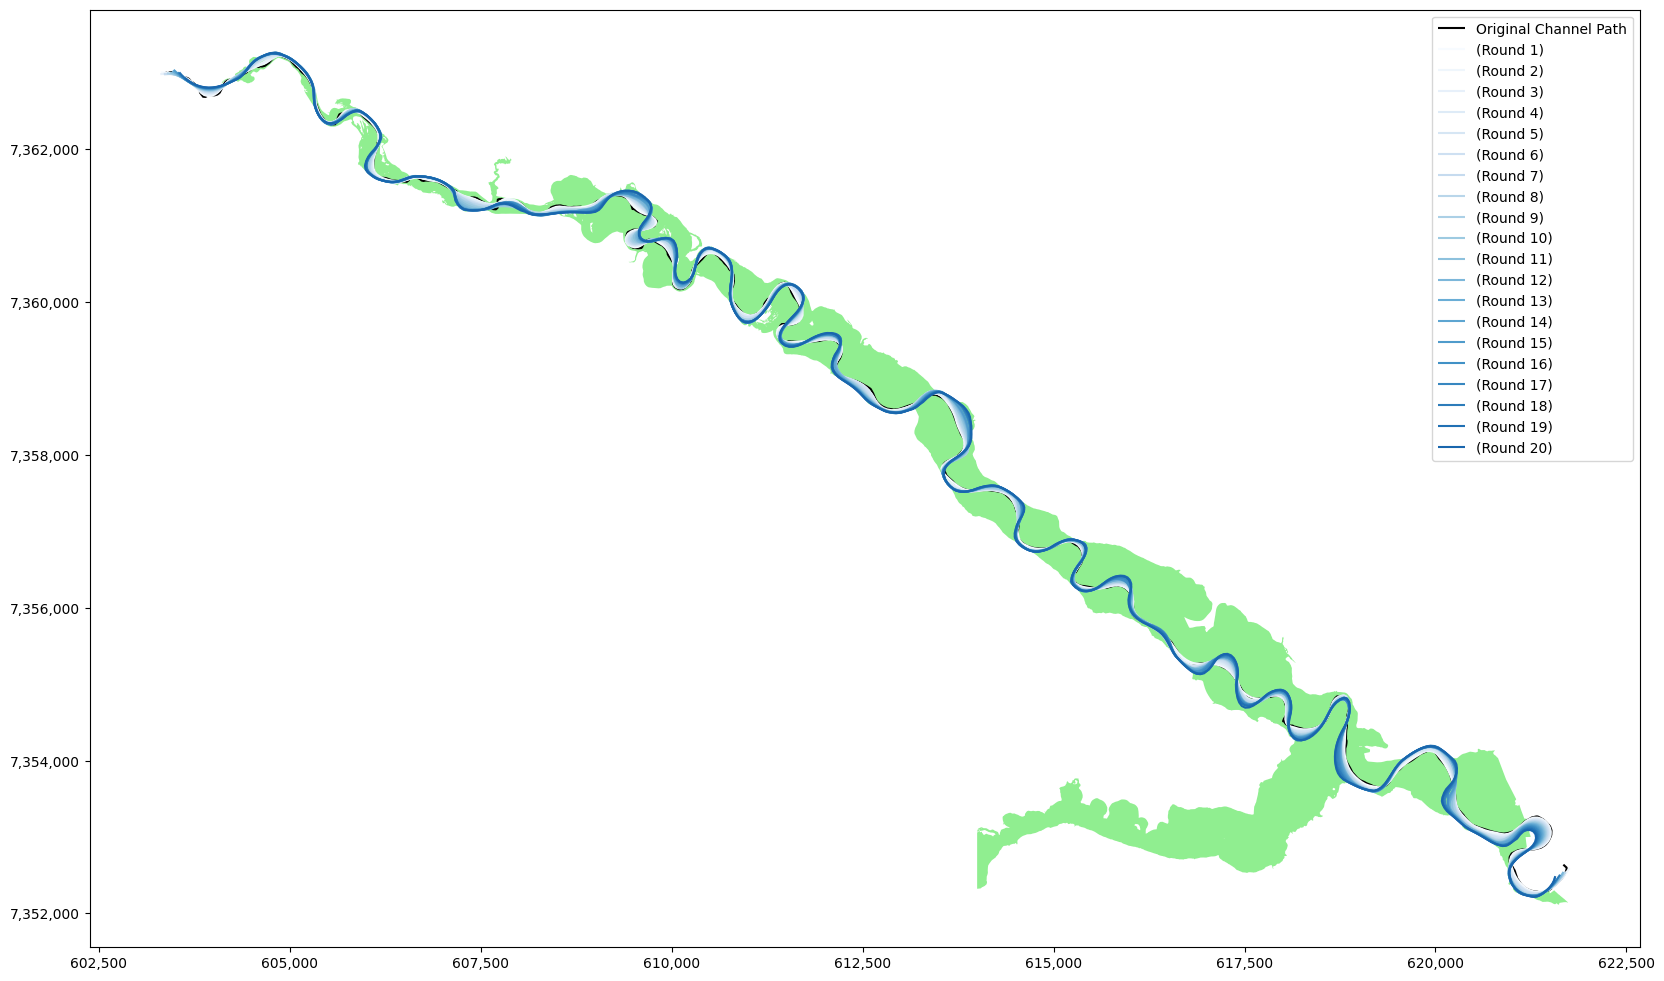

In [45]:
#ALGORITMI 
#REVERSE MIGRATION

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, p_before_next_inflectionpoint, feasible_region):
    new_points = {}
    nurbs = {}
    nurbs_gdf = {}
    blacklist = []

    for sk in range(N_s):
        # Initialize a GeoDataFrame to store the new points
        new_points[sk] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'halfmeander'])
    
        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], p_before_next_inflectionpoint)
        # Define halfmeanders
        define_halfmeander(channel_path, inflection_points)
        # Add into new_points
        new_points[sk]['halfmeander'] = channel_path['halfmeander']

        #TÄHÄN TSEKKI TULEEKO UUSIA OXBOWLAKEJA
        channel_path, oxbows = new_oxbow(channel_path, inflection_points, 50) #JOKU VIKA channelpathissa top pointin kanssa
        print("uus ox" , oxbows)

        top = define_top_points(inflection_points, channel_path)
        
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        # Add into new_points
        new_points[sk]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of the current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        #D_direction, L_direction = define_directions(inflection_points) # 90

        D_direction, L_direction = define_directions_top(inflection_points, top) # huippu

        print("d", D_direction, "L", L_direction)

        '''Liikkumisen määrä näitä muuttamalla'''
        
        # Set mean and standard deviation for the Gaussian distribution
        mean_offset = 20
        std_dev_offset = 5

        # Sample horizontal and lateral offsets from Gaussian distribution

        '''Näitä muuttamalla: Pure lateral reverse migration, Pure reverse downstream migration, Mixed reverse migration, Natural reverse migration with probability distribution accepting negative offsets of lateral and downstream migration'''
    
        #OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        OD = np.zeros(N_hm)

        OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OL = np.zeros(N_hm)


        # Sample smoothing values sL and sD from a uniform distribution
        if np.all(OD) == 0:
            max_od = 0
        else:
            max_od = max(np.abs(OD))
        
        if np.all(OL) == 0:
            max_ld = 0
        else:
            max_ld = max(np.abs(OL))

        min_sD = 0
        max_sD = 2 * max_od

        min_sL = 0
        max_sL = 2 * max_ld

        sD = np.random.uniform(min_sD, max_sD, N_hm)  # tää nolla jos OD nollavektori
        
        sL = np.random.uniform(min_sL, max_sL, N_hm) # tää nolla jos OL nollavektori
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one halfmeander
            pm = (channel_path['halfmeander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            
            #print(OL)
            #print("liikkuu metreissä D-suuntaan :", mig_D)
            #print("liikkuu metreissä L-suuntaan :", mig_L)
        
            #print("pisteet:", filtered_pm['geometry'])
            #print("D-suunta:", D_direction[hm]) #NÄÄÄ PITÄÄÄÄ TSEKKAA VIEL OIKEIKS
            #print("L-suunta: " , L_direction[hm] )


            #Move points

            for pn in range(len(filtered_pm['geometry'])):

                if 0 == 0: #??????????????????????????????????? wtf oon ajatellu? parempi ehto kun parillinen pariton hm?

                    new_point = (
                        filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *   L_direction[hm][0])) ,
                        filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *   L_direction[hm][1]))
                        )
                    if not np.isnan(new_point).all():
                        newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                        newpoint_list.append(newpoint)
                    else:
                        newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                        newpoint_list.append(Point(newpoint)) 
             
                
                else:
                    new_point = (
                        filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *  -L_direction[hm][0])) ,
                        filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *  -L_direction[hm][1]))
                        )
                    if not np.isnan(new_point).all():
                        newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                        newpoint_list.append(newpoint)
                    else:
                        newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                        newpoint_list.append(Point(newpoint)) 
                
                
        # Add new points to the GeoDataFrame
        new_points[sk]['geometry'] = newpoint_list


        # NURBS line of new points
        nurbs[sk], nurbs_gdf[sk] = create_nurbs((new_points[sk]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # update new path to next round
        channel_path = create_breakpoints(nurbs[sk], 75)

        
        
    #print(uudet_pisteet)   

        
    #kuvakoko
    fig, ax = plt.subplots(figsize=(20, 15))

        # x ja y akselit
    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))


    sallittu_alue.plot(ax=ax, color = 'lightgreen')


    # Plot the original channel_path
    joen_keskiviiva.plot(ax=ax, color='black', label='Original Channel Path')
    #channel_path.plot(ax=ax, cmap='jet', markersize=8)
    
    # Plot the moved points on the same axis
    #for i in range (len(new_points)):
    #    new_points[i].plot(ax=ax, color=f'C{i}', label=f'Moved Points (Round {i+1})', markersize = 20)

    # Plot the moved points on the same axis
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        # Plottaa NURBS-viiva
        gpd.GeoDataFrame(geometry=[nurbs[i]]).plot(ax=ax, color=color, label=f'(Round {i+1})')

    
    plt.legend()

    plt.show()

      
# Input
N_r = 1
N_s = 20

channel_path = pisteet100
p_before_next_inflectionpoint = 5

sallittu_alue = sallittu_alue

reverse_migration_simulation(N_s, channel_path, p_before_next_inflectionpoint, sallittu_alue)





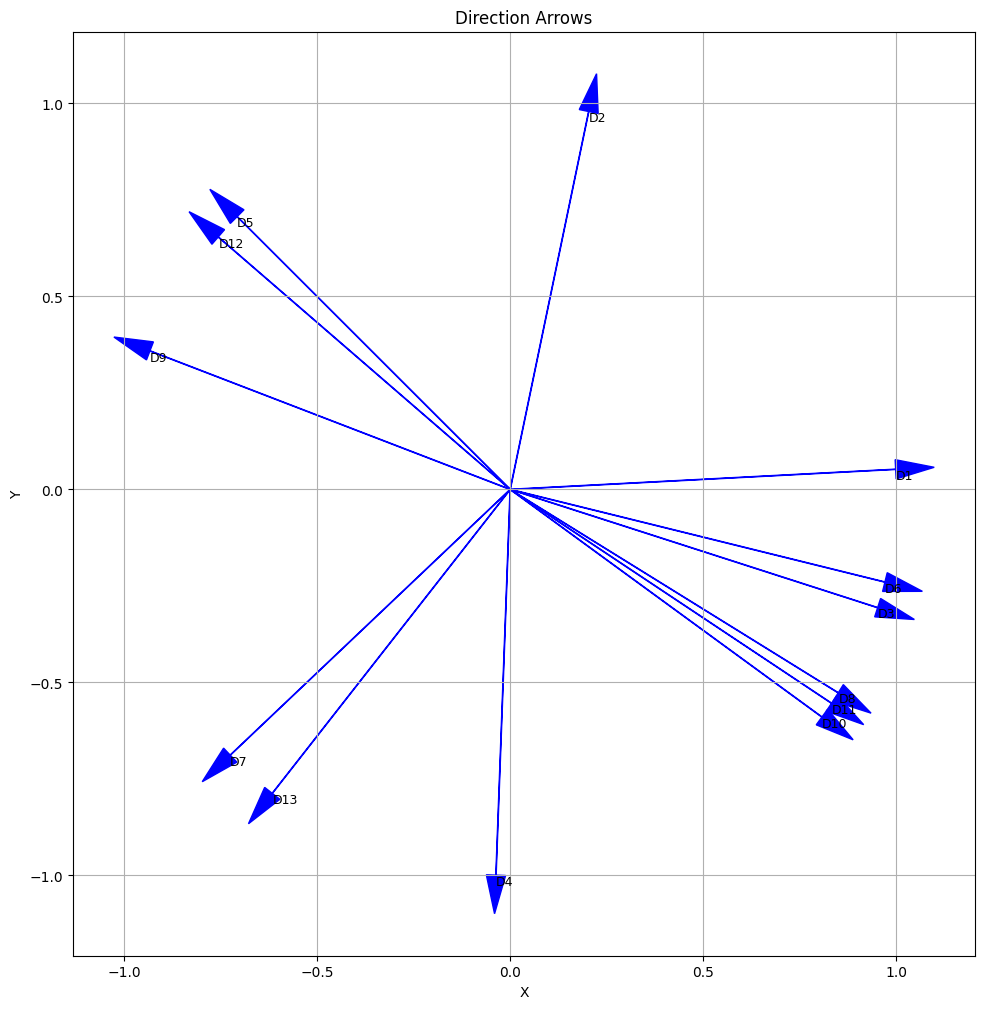

In [46]:
import matplotlib.pyplot as plt

# Define direction vectors
directions = [
    (0.9986406153110658, 0.05212409664575333),
    (0.20337618485935613, 0.979100672776836), (0.9519270816300279, -0.3063247153909362), (-0.03687637908473204, -0.9993198350206), (-0.7073933190953707, 0.7068201271180914), (0.9707725707962694, -0.2400012828915749), (-0.7253399648444739, -0.688390830414974), (0.8499023945004751, -0.5269401482354127), (-0.9333710383250149, 0.3589129487996825), (0.8076380780255521, -0.5896785013235536), (0.8325192229088507, -0.553996158368669), (-0.7563901604371359, 0.6541207267728822), (-0.616424852727199, -0.7874137419046298)
]

# Plot direction arrows
plt.figure(figsize=(13, 12))
for i, (dx, dy) in enumerate(directions):
    plt.arrow(0, 0, dx, dy, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    plt.text(dx, dy, f'D{i+1}', fontsize=9, ha='left', va='top')


plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Direction Arrows')
plt.grid(True)
plt.show()



In [47]:
import random

x1 = [15, 16, 10, 13]
x2 = [17, 19, 20]
x3 = [8, 9, 18]
x4 = [4, 5, 6]

print("x1", random.sample(x1, 1))
print("x2", random.sample(x2, 1))
print("x3", random.sample(x3, 1))
print("x4", random.sample(x4, 1))


x1 [10]
x2 [17]
x3 [9]
x4 [4]
